In [1]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from nice.rascal_coefficients import process_structures

In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
import torch
print(torch.__version__)
print(torch.__path__)

1.8.1+cpu
['/home/pozdn/.local/lib/python3.6/site-packages/torch']


In [3]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
train_subset = "0:5000"  #input for ase.io.read command
test_subset = "5000:6000"  #input to ase.io.read command
environments_for_fitting = 5000  #number of environments to fit nice transfomers
GRID = [150, 200, 350, 500, 750, 1000, 1500, 2000, 2500, 3500, 5000]  #for learning curve

#HYPERS for librascal spherical expansion coefficients
LAMBDA_MAX = 6
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 6,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
MAGIC_NUMBER = 10000
BATCH_SIZE = 500

train_structures = process_structures(ase.io.read('methane.extxyz', index=train_subset))
'''HYPERS = get_optimal_radial_basis_hypers(HYPERS,
                                       train_structures,
                                       expanded_max_radial=50)'''
test_structures = process_structures(ase.io.read('methane.extxyz', index=test_subset))

all_species = get_all_species(train_structures + test_structures)

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean
print(np.min(train_energies), np.max(train_energies))

-8.361618645459657 26.529682184160265


# NICE cython

In [4]:
#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=60),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=60),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=60),
                      None,
                      None,
                      None),
       
    ],
                           )

In [5]:
train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER



100%|██████████| 2/2 [00:00<00:00, 84.68it/s]


In [6]:
nice = get_nice()
np.random.seed(0)
nice.fit(train_coefficients[6][:environments_for_fitting])

In [7]:
def get_features(nice, coefs):
    features = {}
    for i in range(0, coefs.shape[0], BATCH_SIZE):
        now = nice.transform(coefs[i : i + BATCH_SIZE], return_only_invariants = True)
        for key in now.keys():
            if key in features.keys():
                features[key].append(now[key])
            else:
                features[key] = [now[key]]
    for key in features.keys():
        features[key] = np.concatenate(features[key], axis = 0)
    return features

In [8]:
train_features = get_features(nice, train_coefficients[6])
test_features = get_features(nice, test_coefficients[6])
for key in train_features.keys():
    print(train_features[key].shape)

(5000, 12)
(5000, 60)
(5000, 60)
(5000, 60)


In [9]:
for key in train_features.keys():
    print(key, train_features[key].shape)
#print(train_features[1][0:10])
#print(train_features[2][0:10])

1 (5000, 12)
2 (5000, 60)
3 (5000, 60)
4 (5000, 60)


In [10]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

def get_lr(regressor, data_train, data_test, targets_train,
           targets_test):
    result = []
    for el in GRID:
        result.append(estimate_performance(regressor, data_train[:el], data_test,
                                           targets_train[:el], targets_test))
    return result

(5000, 12)
(5000, 72)
(5000, 132)
(5000, 192)


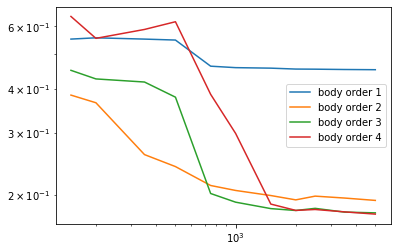

In [11]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# NICE pytorch

In [12]:
from pytorch_prototype.nice_blocks import *
from pytorch_prototype.utilities import *

In [13]:
def split(coefficients):
    lambd_max = max(coefficients.keys())
    even, odd = {}, {}
    for lambd in range(lambd_max + 1):
        if lambd % 2 == 0:
            even[str(lambd)] = coefficients[lambd]
        else:
            odd[str(lambd)] = coefficients[lambd]
    return even, odd


train_coefficients_all = get_coefs(train_structures, HYPERS, all_species)
test_coefficients_all = get_coefs(test_structures, HYPERS, all_species)
for key in train_coefficients_all.keys():
    train_coefficients_all[key] *= MAGIC_NUMBER
    test_coefficients_all[key] *= MAGIC_NUMBER
    
central = get_central_species(train_structures)
mask = central == 6
train_coefficients = {}
for key in train_coefficients_all.keys():
    train_coefficients[key] = train_coefficients_all[key][mask]
    

central = get_central_species(test_structures)
mask = central == 6
test_coefficients = {}
for key in test_coefficients_all.keys():
    test_coefficients[key] = test_coefficients_all[key][mask]
                                                
    
train_even, train_odd = split(train_coefficients)
test_even, test_odd = split(test_coefficients)


for key in train_even.keys():
    print(key, train_even[key].shape)
for key in test_even.keys():
    print(key, test_even[key].shape)

0 torch.Size([5000, 12, 1])
2 torch.Size([5000, 12, 5])
4 torch.Size([5000, 12, 9])
6 torch.Size([5000, 12, 13])
0 torch.Size([1000, 12, 1])
2 torch.Size([1000, 12, 5])
4 torch.Size([1000, 12, 9])
6 torch.Size([1000, 12, 13])


In [14]:
blocks = [BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(60)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(60)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(60))]
nice = NICE(blocks)
for_fit_even, for_fit_odd = {}, {}
for key in train_even.keys():
    for_fit_even[key] = train_even[key][:environments_for_fitting]
    print(for_fit_even[key].shape)
for key in test_odd.keys():
    for_fit_odd[key] = train_odd[key][:environments_for_fitting]
    print(for_fit_odd[key].shape)
np.random.seed(0)   
nice.fit(for_fit_even, for_fit_odd)

torch.Size([5000, 12, 1])
torch.Size([5000, 12, 5])
torch.Size([5000, 12, 9])
torch.Size([5000, 12, 13])
torch.Size([5000, 12, 3])
torch.Size([5000, 12, 7])
torch.Size([5000, 12, 11])


/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.84149e-09): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.40028e-08): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.41176e-09): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.50512e-09): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.18038e-08): result may not be accurate.
  overwrite_a=True).T
/home/pozdn/.local/lib/python3.6/site-pa

In [15]:
def convert(features):
    result = {}
    for i in range(len(features)):
        #print(features[i].keys())
        result[i + 1] = features[i]['0'].squeeze().data.cpu().numpy()
    return result

In [16]:
train_features, _ = nice(train_even, train_odd)
train_features = convert(train_features)

test_features, _ = nice(test_even, test_odd)
test_features = convert(test_features)

In [17]:
for key in train_features.keys():
    print(key, train_features[key].shape)

1 (5000, 12)
2 (5000, 60)
3 (5000, 60)
4 (5000, 60)


In [18]:
'''print(train_features[1][0:10])
print(train_features[2][0:10])'''

'print(train_features[1][0:10])\nprint(train_features[2][0:10])'

(5000, 12)
(5000, 72)
(5000, 132)
(5000, 192)


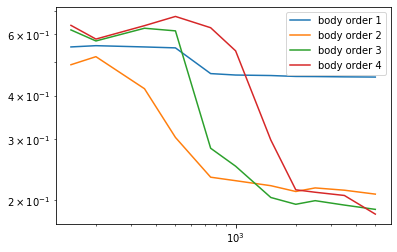

In [19]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

(5000, 192)
(1000, 192)


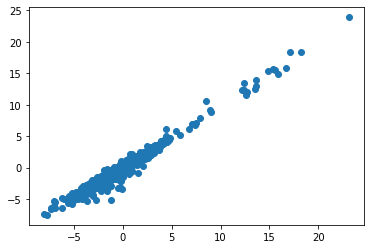

(192,)


In [24]:
print(train.shape)
rgr = BayesianRidge(fit_intercept = False)
rgr.fit(train, train_energies)
predictions = rgr.predict(test)
print(test.shape)
plt.plot(test_energies, predictions, 'o')
plt.show()
best_weight = rgr.coef_
print(best_weight.shape)

In [25]:
class Dummy(torch.nn.Module):
    def __init__(self):
        super(Dummy, self).__init__()
    def forward(self, X):
        return {"energy" : torch.zeros(X[0].shape[0], 1)}
    
class NICE_predictions(torch.nn.Module):
    def __init__(self, nice, in_shape, out_shape):
        super(NICE_predictions, self).__init__()
        self.nice = nice
        self.linear = nn.Linear(in_shape, out_shape, bias = False)
        
    def forward(self, X):
        even, odd = split(X)
        features, _ = nice(even, odd)
        conc = []
        for i in range(len(features)):
            conc.append(features[i]['0'].squeeze())
        conc = torch.cat(conc, dim = 1)
        print(conc[0,0:20])
        print(conc.shape)
        return {"energy": self.linear(conc)}

In [26]:
model = NICE_predictions(nice, 192, 1)
print(model.linear.weight.shape)
with torch.no_grad():
    best_weight = torch.from_numpy(best_weight)[None, :]
    model.linear.weight.copy_(best_weight)
print(model.linear.weight[0, 0:20])
result = model(test_coefficients)
print(result["energy"].shape)

torch.Size([1, 192])
tensor([-1.2637e-02, -5.8609e+00,  1.8118e+01,  1.8235e+01,  3.8879e+02,
         9.6655e+00, -1.0108e+00,  1.5269e-06,  3.6353e-07,  4.0643e-07,
         1.4703e-07,  7.0024e-08,  1.5348e+01,  2.2243e+00,  6.5859e+00,
         1.0440e-01,  1.2336e-01, -4.9699e-01,  7.8233e-01,  5.6689e+00],
       grad_fn=<SliceBackward>)
tensor([ 1.1974e+00,  1.9887e-02, -1.1737e-01, -7.3614e-04,  3.0733e-03,
         1.1112e-05, -7.4694e-07,  3.1213e-08,  7.4314e-09,  8.3032e-09,
         3.0098e-09,  1.4295e-09,  2.6977e-03, -4.1297e-02,  7.0663e-03,
        -1.7989e-02, -2.0220e-02,  1.9680e-02, -1.0402e-02,  2.6114e-03],
       grad_fn=<SliceBackward>)
torch.Size([1000, 192])
torch.Size([1000, 1])


In [27]:
models = {'1' : Dummy(), '6' : model}
atomistic = Atomistic(models)

In [28]:
print(test_coefficients_all[0].shape)

torch.Size([5000, 12, 1])


In [29]:
result = atomistic(test_coefficients_all, central_species = get_central_species(test_structures),
                   structural_indices = get_structural_indices(test_structures))
test_predictions = result['energy'].data.cpu().numpy().squeeze()

tensor([ 1.1974e+00,  1.9887e-02, -1.1737e-01, -7.3614e-04,  3.0733e-03,
         1.1112e-05, -7.4694e-07,  3.1213e-08,  7.4314e-09,  8.3032e-09,
         3.0098e-09,  1.4295e-09,  2.6977e-03, -4.1297e-02,  7.0663e-03,
        -1.7989e-02, -2.0220e-02,  1.9680e-02, -1.0402e-02,  2.6114e-03],
       grad_fn=<SliceBackward>)
torch.Size([1000, 192])


In [30]:
#print(test[0, 0:20])
print(rgr.coef_[0:20])
print(print(atomistic.models['6'].linear.weight[0, 0:20]))

[-1.26369600e-02 -5.86088648e+00  1.81175633e+01  1.82350691e+01
  3.88788900e+02  9.66549457e+00 -1.01084120e+00  1.52686819e-06
  3.63533656e-07  4.06426251e-07  1.47030702e-07  7.00240180e-08
  1.53482738e+01  2.22426358e+00  6.58592998e+00  1.04404739e-01
  1.23357338e-01 -4.96988013e-01  7.82327274e-01  5.66892200e+00]
tensor([-1.2637e-02, -5.8609e+00,  1.8118e+01,  1.8235e+01,  3.8879e+02,
         9.6655e+00, -1.0108e+00,  1.5269e-06,  3.6353e-07,  4.0643e-07,
         1.4703e-07,  7.0024e-08,  1.5348e+01,  2.2243e+00,  6.5859e+00,
         1.0440e-01,  1.2336e-01, -4.9699e-01,  7.8233e-01,  5.6689e+00],
       grad_fn=<SliceBackward>)
None


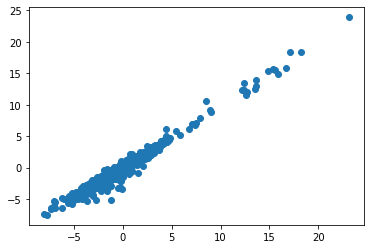

In [31]:
plt.plot(test_energies, test_predictions, 'o')
plt.show()

In [32]:
#forces = atomistic.predict_forces()

In [33]:
test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR

coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)
for key in coef_der_test.keys():
    coef_der_test[key] *= MAGIC_NUMBER

In [34]:
for key in test_coefficients_all.keys():
    test_coefficients_all[key].requires_grad = True
prediction_forces = atomistic.get_forces(coef_der_test, central_indices_test, derivative_indices_test, 
                                         test_coefficients_all,
                                         structural_indices = get_structural_indices(test_structures),
                                         central_species = get_central_species(test_structures))


tensor([ 1.1974e+00,  1.9887e-02, -1.1737e-01, -7.3614e-04,  3.0733e-03,
         1.1112e-05, -7.4694e-07,  3.1213e-08,  7.4314e-09,  8.3032e-09,
         3.0098e-09,  1.4295e-09,  2.6977e-03, -4.1297e-02,  7.0663e-03,
        -1.7989e-02, -2.0220e-02,  1.9680e-02, -1.0402e-02,  2.6114e-03],
       grad_fn=<SliceBackward>)
torch.Size([1000, 192])


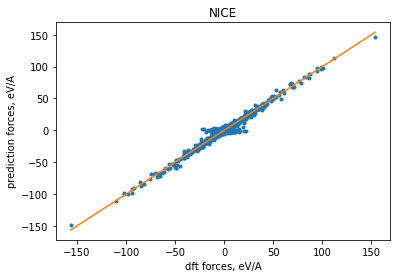

In [35]:
plt.plot(test_forces.reshape([-1]), prediction_forces.data.cpu().numpy().reshape([-1]),
         'o', markersize = 3)
min_f = np.min(test_forces)
max_f = np.max(test_forces)
plt.plot([min_f, max_f], [min_f, max_f])
plt.xlabel("dft forces, eV/A")
plt.ylabel("prediction forces, eV/A")
plt.title("NICE")
plt.savefig("ready.pdf", bbox_inches = 'tight')
plt.show()

In [36]:
print(lr[-1])
print(get_relative_performance(test_forces.reshape([-1]),
                               prediction_forces.data.cpu().numpy().reshape([-1])))

0.18242476729851353
0.19589084009644545


INITIAL: 
0.2802526363315779
0.36032098406318647

INITIAL WITH OPTIMAL BASIS:
0.5965028311506828
1.1745494999259651

BIG SAME DATASET SIZE:
0.19612787870778658
0.23920163769932476

40:
0.196692075027405
0.20770218304449836